Welcome to Week 4, where we delve into event studies with a focus on how information impacts security prices. This topic is central to understanding market dynamics and is particularly relevant for analysts, investors, and policymakers who need to decipher the complexities of the financial markets.

Event studies are a powerful statistical method used to assess the impact of corporate, economic, or political events on the value of securities. By analyzing the behavior of stock prices before and after a specific event, we can gain insights into how information is absorbed and acted upon in the markets. 

As we dive deeper into working with data in Python, please read Chapter 7. Data Cleaning and Preparation and Chapter 8. Data Wrangling: Join, Combine, and Reshape in McKinney (2022).   (You can skip 7.3 Extension Data Types.)

These chapters will prepare you for some of the data wrangling you'll need for the next projects.

McKinney, W. (2022). Python for data analysis. O'Reilly Media. (https://learning.oreilly.com/library/view/python-for-data/9781098104023/ch07.html#pandas_missing_filtering)

# Package Imports, WRDS Connection

In [79]:
import pandas as pd
pd.set_option('display.max_columns', None) # display all columns

import numpy as np

import os
from dotenv import load_dotenv
from sqlalchemy import create_engine

from scipy.stats import ttest_ind  # independent t-test function

import seaborn as sns # for pairplot function
# ensure plots are output in line with command cells
%matplotlib inline  

# we will use plotnine for our custom plots
from plotnine import ggplot, aes, geom_histogram, geom_line, geom_point, geom_hline, geom_density, geom_segment, \
                        facet_wrap, labs, theme, ggtitle, theme_minimal, scale_x_continuous, scale_y_continuous

In [2]:
load_dotenv()
connection_string = (
  "postgresql+psycopg2://"
 f"{os.getenv('WRDS_USER')}:{os.getenv('WRDS_PASSWORD')}"
  "@wrds-pgdata.wharton.upenn.edu:9737/wrds"
)
wrds = create_engine(connection_string, pool_pre_ping=True)

# Examining the Effect of Positive Earnings Surprises on Stock Returns: An Event Study

This study aims to investigate the impact of positive earnings surprises on stock returns using an event study methodology. By analyzing the market reaction to earnings announcements that exceed expectations, we seek to understand the extent to which positive earnings surprises influence stock prices. The findings from this study will provide valuable insights into market efficiency and the informational content of earnings announcements.

Earnings announcements are critical events for investors as they provide updated information on a firm's financial performance. A positive earnings surprise occurs when a company's reported earnings exceed analysts' expectations. Such surprises can signal better-than-expected performance, potentially leading to significant market reactions. This study aims to quantify the effect of positive earnings surprises on stock returns, enhancing our understanding of how markets process new information.

The event study will shed light on the relationship between positive earnings surprises and stock returns. By examining the market reaction to earnings announcements, this study aims to provide a deeper understanding of the mechanisms through which new information is incorporated into stock prices. The results will have implications for investors, analysts, and policymakers in their efforts to interpret and respond to earnings announcements.

Our research hypothesis is as follows:

**H1: Positive earnings surprises lead to a statistically significant increase in stock returns.**

This hypothesis posits that when a company reports earnings that exceed analysts' expectations (defined as a positive earnings surprise), the stock price will experience a statistically significant positive abnormal return. This is based on the notion that earnings surprises provide new, positive information to the market, which investors will react to by bidding up the stock price. The hypothesis can be tested by comparing the abnormal returns on event days (days with positive earnings surprises) to non-event days within the defined event window. A significant positive difference would support the hypothesis that positive earnings surprises are associated with increased stock returns.

We define the timeframe of our analysis as 1960 to 2022.

In [3]:
start_date = "01/01/1960"
end_date = "12/31/2022"

## Collect Data

The data for this week's example comes from Compustat and CRSP.  We are going to select a number of firms, download financial statement data and stock returns.  Then we calcuate our special accounting measure and combine the two data sources into one simple table. 

### Tickers

In [4]:
# you can select tickers manually like this:
tickers_ = ['DHR', 'COST']
# Convert list of tickers into a string format suitable for SQL query
formatted_tickers = "'" + "', '".join(tickers_) + "'"

We select the tickers using the WRDS DB that contains the SP500 components to have a larger set of observations.  

In [14]:
# or query the WRDS DB for all tickers in the SP500 with end date post study start date
ticker_query = (
    "SELECT DISTINCT stn.ticker "
    "FROM  	crsp.dsp500list as dsp500list "
    "LEFT JOIN crsp.stocknames as stn "
    "ON dsp500list.permno = stn.permno "
   f"WHERE dsp500list.ending > '2023-01-01' "
)

In [15]:
tickers_ = pd.read_sql_query(
    sql=ticker_query,
    con=wrds,
)
tickers_ = tickers_.dropna()

In [17]:
# truncate number of tickers for illustration purposes.
tickers_ = tickers_[0:400]
# format tickers so they can be used in a query
formatted_tickers = "'" + "', '".join(list(tickers_.ticker)) + "'"

### Earnings

We will read the following fields from Compustat for the calculation of earnings surprises: 
- Earnings Per Share (Diluted) - Excluding Extraordinary items (epsfxq)
- Common Shares for Diluted EPS (cshfdq)
- Special Items (spiq) 
- Adjustment Factor (Company) - Cumulative by Ex-Date (ajexq)
- Price Close - Quarter (prccq) 

In [18]:
earnings_query = (
    "SELECT tic , datadate ,  "
    "epsfxq, cshfdq, spiq, ajexq, prccq "
    "FROM  	comp.fundq "
    "WHERE (indfmt='INDL' AND datafmt='STD' AND popsrc='D' AND consol='C')"
   f"AND tic IN ({formatted_tickers}) "
   f"AND datacqtr IS NOT NULL "
   f"AND rdq  BETWEEN '{start_date}' AND '{end_date}' "
)

In [19]:
earnings_data_ = pd.read_sql_query(
    sql=earnings_query,
    con=wrds,
)

In [ ]:
# Convert date column to datetime
earnings_data_['date'] = pd.to_datetime(earnings_data_['datadate'])
earnings_data_['ticker'] = earnings_data_['tic']

In [21]:
earnings_data_ = earnings_data_.drop([ "tic","datadate"], axis=1)  # remove original date
earnings_data_ = earnings_data_.dropna()  # remove NA values

### Window Stock Returns

Next, we fetch the daily stock prices for each ticker to calculate the returns in the period of three days before to three days after the earnings announcement date.

In [22]:
price_query = (
    "SELECT  stn.ticker, dsf.date, AVG(dsf.prc) AS prc, AVG(dsf.ret) AS ret "
    "FROM crsp.dsf as dsf "
    "LEFT JOIN crsp.stocknames as stn "
    "ON dsf.permno = stn.permno "
   f"WHERE stn.ticker IN ({formatted_tickers}) "
   f"AND dsf.date BETWEEN '{start_date}' AND '{end_date}' "
    "GROUP BY dsf.date, stn.ticker"
)

In [23]:
price_data_ = pd.read_sql_query(
    sql=price_query,
    con=wrds,
)
# Convert date column to datetime
price_data_['date'] = pd.to_datetime(price_data_['date'])
# Sort by ticker and date
price_data_.sort_values(by=['ticker', 'date'], inplace=True)

We use the shift command to select the timeframe and calculate the window returns using this function:

In [27]:
# Calculate the return using three observations before and after
def calculate_window_return(df):
    # Adding previous and next prices
    df['price_3_days_before'] = df['prc'].shift(3)
    df['price_3_days_after'] = df['prc'].shift(-3)

    # Calculate window returns
    df['rolling_3d_before_after'] = df.apply(
        lambda row: (row['price_3_days_after'] - row['price_3_days_before']) / (row['price_3_days_before']  + 1e-10 )
        if pd.notnull(row['price_3_days_before']) and pd.notnull(row['price_3_days_after'])
        else None,
        axis=1
    )
    return df

In [28]:
# Apply the function to each ticker seperately
window_returns_ = price_data_.groupby('ticker').apply(calculate_window_return, include_groups=False)

We can see that the first three rows and the last three rows of the window returns are NA for each ticker. 

In [29]:
window_returns_.loc['TSLA']

,date,prc,ret,price_3_days_before,price_3_days_after,rolling_3d_before_after
3342350,2010-06-29,23.89,NaN,NaN,19.20,NaN
3342725,2010-06-30,23.83,-0.002511,NaN,16.11,NaN
3343100,2010-07-01,21.96,-0.078473,NaN,15.80,NaN
3343475,2010-07-02,19.20,-0.125683,23.89000,17.46,-0.269150
3343850,2010-07-06,16.11,-0.160938,23.83000,17.40,-0.269828
...,...,...,...,...,...,...
4563105,2022-12-23,123.15,-0.017551,137.80000,121.82,-0.115965
4563505,2022-12-27,109.10,-0.114089,137.57001,123.18,-0.104601
4563905,2022-12-28,112.71,0.033089,125.35000,NaN,NaN
4564305,2022-12-29,121.82,0.080827,123.15000,NaN,NaN


In [30]:
window_returns_ = window_returns_.reset_index().dropna()  # remove first and last three observations for each asset

### Benchmark Returns

We collect benchmark market returns, because our research is interested in abnormal returns around earnings announcements.  Abnormal returns are the difference between asset returns and market returns. 

In [31]:
benchmark_returns_query = (
"SELECT date, vwretd "
"FROM crsp.dsi  "
f"WHERE date BETWEEN '{start_date}' AND '{end_date}' ")

benchmark_returns_ = pd.read_sql_query(
    sql=benchmark_returns_query,
    con=wrds,
)

In [32]:
benchmark_returns_['date'] = pd.to_datetime(benchmark_returns_['date'])
# Sort by ticker and date
benchmark_returns_.sort_values(by=[ 'date'], inplace=True)

In [33]:
# function to calculate the compounded return over a window
def compounded_return(x):
    return (1 + x).prod() - 1

# Calculation of 3-day before and after rolling returns
# We need a window of 7 days: 3 days before, the current day, and 3 days after
benchmark_returns_['benchmark_rolling_3d_before_after'] = benchmark_returns_['vwretd'].rolling(window=7, center=True).apply(compounded_return, raw=True)
benchmark_returns_.dropna(inplace=True)

In [34]:
benchmark_returns_

,date,vwretd,benchmark_rolling_3d_before_after
3,1960-01-07,-0.006302,-0.023012
4,1960-01-08,-0.003181,-0.027999
5,1960-01-11,-0.011428,-0.029963
6,1960-01-12,-0.005640,-0.025608
7,1960-01-13,-0.005100,-0.027400
...,...,...,...
15850,2022-12-20,0.001879,-0.036009
15851,2022-12-21,0.014642,-0.016108
15852,2022-12-22,-0.014002,-0.018111
15853,2022-12-23,0.005465,0.009602


## Calculate Additional Variables and Merge Datasets

### Calculate Unexpected Earnings

Now we calculate Standardized Unexpected Earnings (SUE), a financial metric used to measure the magnitude of an earnings surprise, that is, how much the actual earnings reported by a company differ from the expected earnings forecasted by analysts.  We make the naive assumption that the forecasts are purely based on historical earnings from the last period to illustrate the process. 

(For a detailed review see Livnat & Mendenhall (2006)).

The SUE score is calculated by taking the difference between the actual earnings per share (EPS) and the expected EPS, and then dividing this difference by the standard deviation of EPS estimates. This standardization allows for comparison across different companies or different periods for the same company, regardless of the absolute level of earnings or volatility in earnings estimates.

SUE is a useful indicator in financial analysis and investment decision-making because:

- High SUE values can indicate that a company performed significantly better than market expectations, which might lead to positive stock price movements as the market adjusts its valuation of the company.
- Low SUE values (or negative ones) indicate that a company's earnings were below expectations, which could lead to negative stock price movements.

Analysts and investors often look at SUE values along with other financial metrics to assess company performance, stock valuation, and predict future price movements based on earnings surprises.

Livnat, J., & Mendenhall, R. R. (2006). Comparing the post–earnings announcement drift
for surprises calculated from analyst and time series forecasts. Journal of Accounting
Research, 44(1), 177-205.

In [35]:
def calculate_sue(group):
    group = group.sort_values('date') 
    group['lag_eps'] = group['epsfxq'].shift(1)
    group['lag_shares'] = group['cshfdq'].shift(1)
    group['lag_spiq'] = group['spiq'].shift(1)
    group['lag_adj'] = group['ajexq'].shift(1)
    
    # Adjusting EPS by excluding special items
    group['adjusted_actual_eps'] = (group['epsfxq'] - 0.65 * group['spiq'] / group['cshfdq']) / group['ajexq']
    group['adjusted_expected_eps'] = (group['lag_eps'] - 0.65 * group['lag_spiq'] / group['lag_shares']) / group['lag_adj']
    
    # Calculate SUE
    group['sue'] = (group['adjusted_actual_eps'] - group['adjusted_expected_eps']) / group['adjusted_expected_eps'].std()
    
    group = group.dropna()

    return group

# Apply function by group
sue_ = earnings_data_.groupby(['ticker']).apply(calculate_sue, include_groups=False) 

In [36]:
sue_ = sue_.reset_index()

### Calculate Abnormal Returns

In [37]:
# create the abnormal returns dataset
abnormal_returns_ = pd.merge(window_returns_.loc[:,["ticker","date","ret","rolling_3d_before_after"]], benchmark_returns_.loc[:,["date","vwretd","benchmark_rolling_3d_before_after"]], on=["date"], how='inner')

In [38]:
abnormal_returns_['abnormal_return'] = abnormal_returns_["rolling_3d_before_after"] - abnormal_returns_["benchmark_rolling_3d_before_after"]
abnormal_returns_['daily_abnormal_return'] = abnormal_returns_["ret"] - abnormal_returns_["vwretd"]

### Merge Financial Statement and Window-Returns

In [39]:
# combine financial statement date with returns data
merged_df_ = pd.merge(sue_.loc[:,["ticker","date","sue"]], abnormal_returns_.loc[:,["ticker","date","abnormal_return"]], on=['ticker', 'date'], how='inner')

## Save / Load Data

In [42]:
# save the data for future processing

datastore_ = pd.HDFStore('week4.h5')
datastore_['abnormal_returns_'] = abnormal_returns_
datastore_['merged_df_'] = merged_df_
datastore_.close()

In [605]:
# load the data - only works if it has previously been saved

datastore_ = pd.HDFStore('week4.h5')
abnormal_returns_ = datastore_['abnormal_returns_'] 
merged_df_ = datastore_['merged_df_'] 
datastore_.close()  

## Final Data Set Review

Let's take a look at our variables to see if we have any distributional challenges.

In [146]:
adjusted_dataset = merged_df_.copy()

SUE looks reasonably distributed for our analysis. 

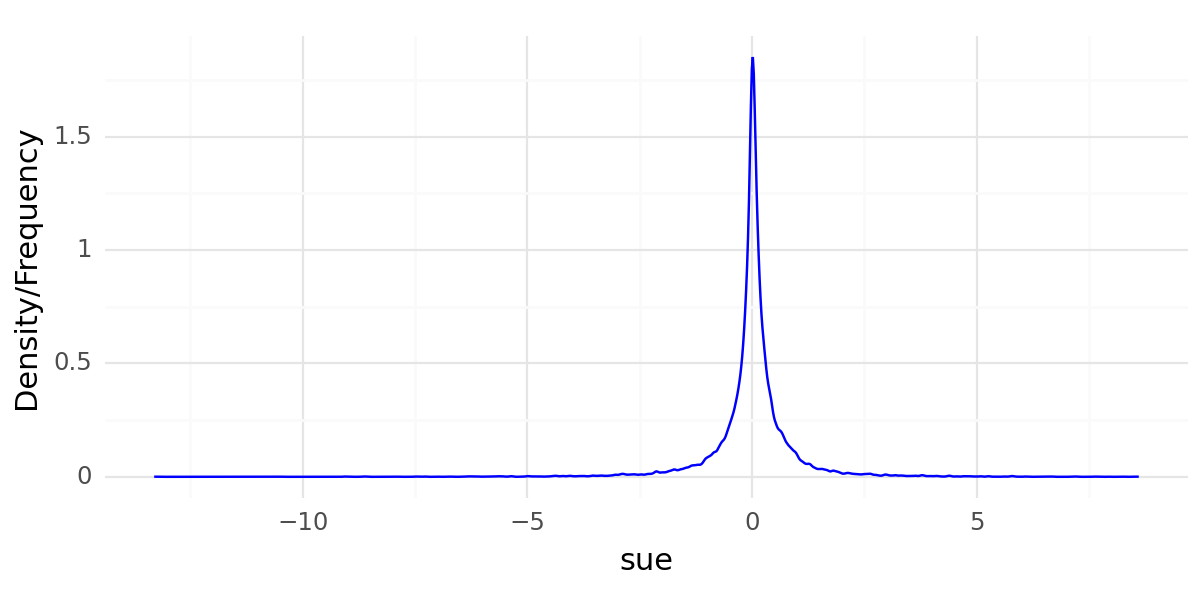

<Figure Size: (600 x 300)>

In [147]:
( ggplot(adjusted_dataset) 
   + geom_density(aes(x='sue', y='stat(density)'), color='blue') 
   + labs(y='Density/Frequency') 
   + theme_minimal()
   + theme(figure_size=(6, 3))
)

Abnormal returns have very heavy tails that we need to deal with, they will skew our results. 

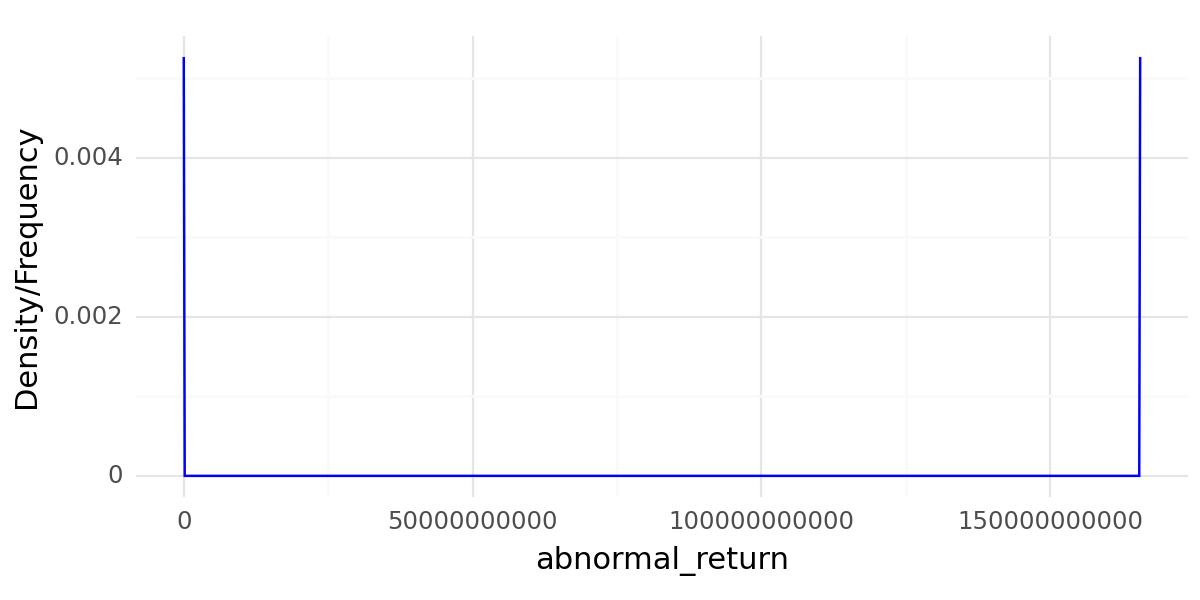

<Figure Size: (600 x 300)>

In [148]:
( ggplot(adjusted_dataset) 
   + geom_density(aes(x='abnormal_return', y='stat(density)'), color='blue') 
   + labs(y='Density/Frequency') 
   + theme_minimal()
   + theme(figure_size=(6, 3))
)

Some of the firm level returns data is clearly out of the ordinary, and will likely skew the analysis, we remove them. 

In [149]:
adjusted_dataset[(adjusted_dataset["abnormal_return"] > 2) | (adjusted_dataset["abnormal_return"] < -2)]

,ticker,date,sue,abnormal_return,positive_surprise
1710,BIO,1999-03-31,0.008813,-3.022248,False
1716,BIO,2001-12-31,0.015449,446.012328,False
1720,BIO,2003-06-30,-0.009527,-2.609570,False
1725,BIO,2004-09-30,-0.008723,-634.963145,False
1726,BIO,2004-12-31,0.001265,424.643189,False
...,...,...,...,...,...
14418,STZ,2016-05-31,0.233275,-356.121029,True
14421,STZ,2017-02-28,-0.344582,-237.016101,False
14423,STZ,2017-08-31,0.138456,-405.530932,True
14434,STZ,2021-11-30,1.538686,-3.628077,True


We remove Bio-Rad from the analysis, since it'll skew our results.

In [150]:
#  this is how we can remove individual assets
#adjusted_dataset = adjusted_dataset[(adjusted_dataset["ticker"] != "BIO") ]

In [151]:
len(adjusted_dataset)

17329

In [152]:
# or remove data based on inclusion criteria
adjusted_dataset = adjusted_dataset[(adjusted_dataset["abnormal_return"] < 2) & (adjusted_dataset["abnormal_return"] > -2)]

This removal only cost us 75 rows of data. 

In [153]:
len(adjusted_dataset)

17254

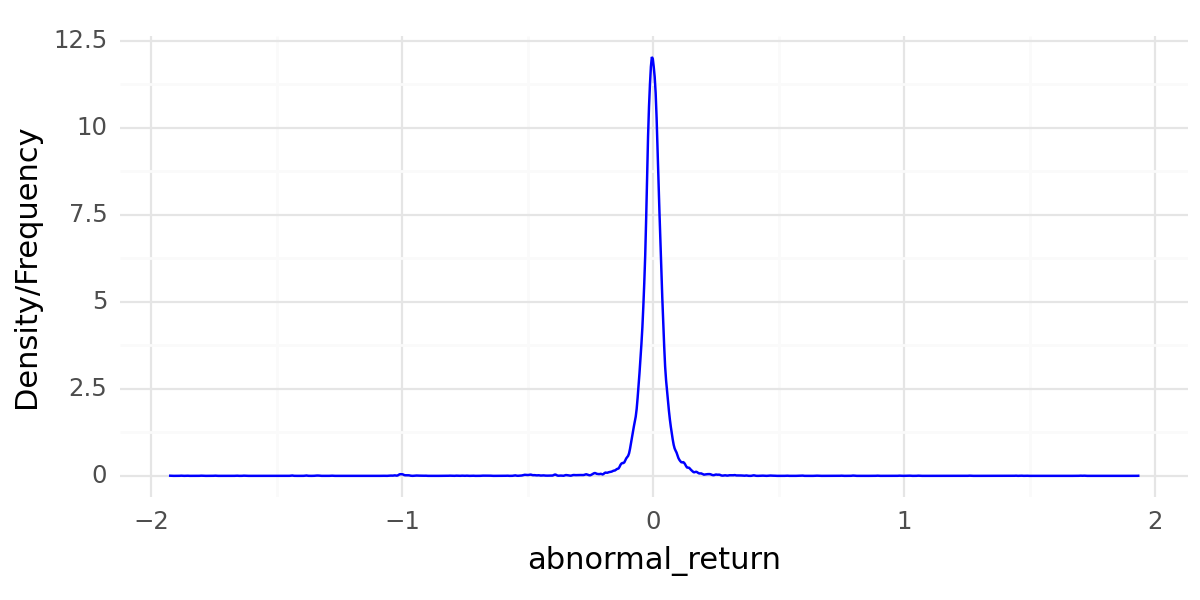

<Figure Size: (600 x 300)>

In [154]:
( ggplot(adjusted_dataset) 
   + geom_density(aes(x='abnormal_return', y='stat(density)'), color='blue') 
   + labs(y='Density/Frequency') 
   + theme_minimal()
   + theme(figure_size=(6, 3))
)

While the distributions are fairly 'spiky', they don't exhibit any meaningful issues with regards to our analysis.

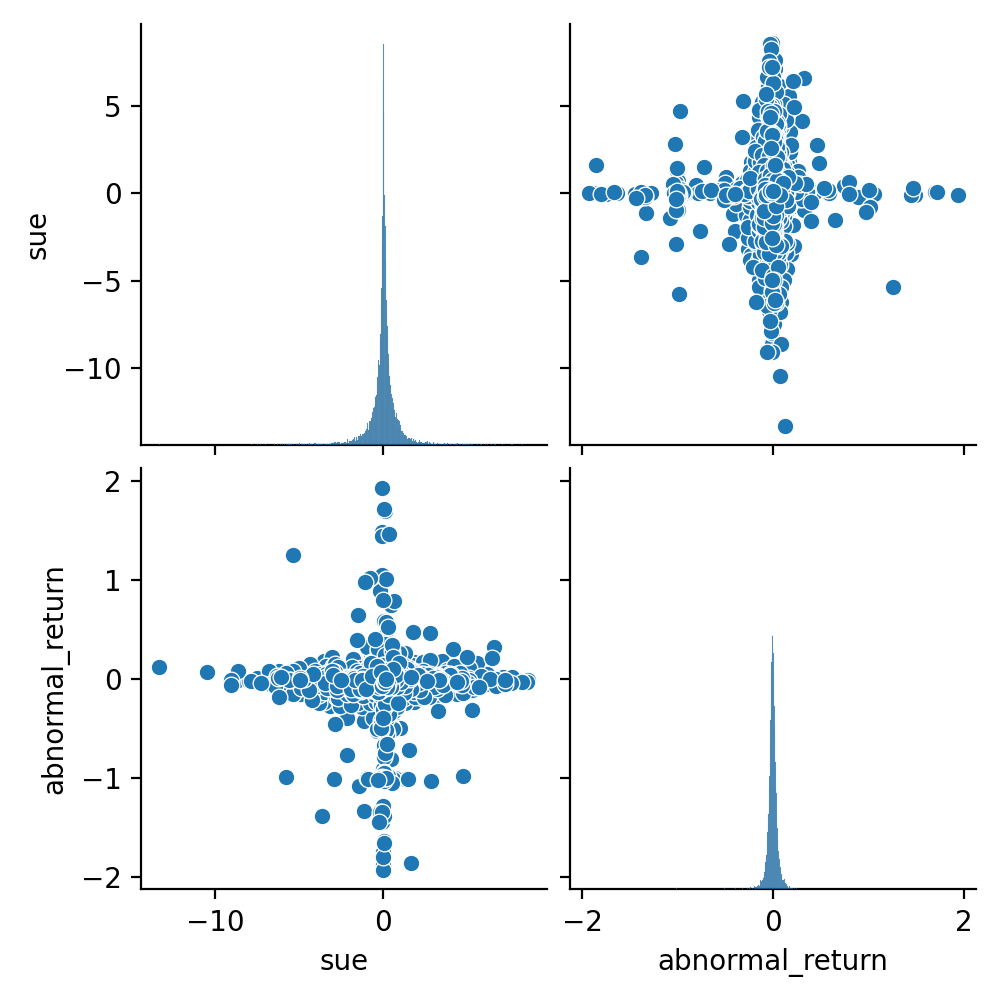

In [155]:
sns.pairplot(adjusted_dataset.reset_index().drop(["index","ticker","date","positive_surprise"],axis=1))

## Statistical Review

In [156]:
df_ = adjusted_dataset.copy()

Calculate the surprise event variable, based on our threshold of surprise.

In [157]:
# calculate event - we set the event threshold to returns above the mean
df_['positive_surprise'] = df_['sue'] > np.mean(df_['sue']) + 0.05

We run the analysis using an indepent samples t-test.

In [158]:
# Run a t-test between groups defined by 'positive_surprise'
t_stat, p_value = ttest_ind(
    df_[df_['positive_surprise']]['abnormal_return'],  # Returns on days with positive surprises
    df_[~df_['positive_surprise']]['abnormal_return'],  # Returns on other days
    nan_policy='omit'  # This option automatically handles NaNs by omitting them
)

print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: 2.6501362377832467, P-value: 0.008053271436730276


## Visualization

Next, we visualize the path that event and non-event returns take around the event timeframe.  In this section we first calculate the cumulative returns around the event (starting 21 days prior to the event), and observe how those returns behave in comparison to non-events. 

In [159]:
# Function to extract the event windows
def get_event_windows(events, returns, event_variable, obs_before_after=21):
    event_indices = events[events[event_variable]].index
    non_event_indices = events[~events[event_variable]].index

    # Function to calculate windows and returns
    def calc_windows(indices):
        window_list = []
        for date in indices:
            pos = events.index.get_loc(date)
            start_pos = max(0, pos - obs_before_after)
            end_pos = min(len(returns) - 1, pos + obs_before_after)
            window = returns.iloc[start_pos:end_pos + 1].copy()
            window['cumulative_return'] = (1 + window['daily_abnormal_return'].fillna(0)).cumprod() - 1
            window['obs_from_event'] = range(start_pos - pos, end_pos - pos + 1)
            window_list.append(window)
        if len(window_list) > 0:
            return pd.concat(window_list)
        else:
            return pd.DataFrame()
    
    # Get windows for event and non-event days
    event_windows = calc_windows(event_indices)
    non_event_windows = calc_windows(non_event_indices)

    return event_windows, non_event_windows

Now we apply the above functions to each ticker and each event.

In [117]:
event_variable_ = "positive_surprise"

# Initialize DataFrames to store the results and calculate event windows for all events
all_event_windows = pd.DataFrame()
all_non_event_windows = pd.DataFrame()

# run this separately for all tickers
for name, group in df_.groupby('ticker'):
    returns_ = abnormal_returns_.loc[abnormal_returns_['ticker'] == name]
    event_windows, non_event_windows = get_event_windows(group, returns_, event_variable_)
    all_event_windows = pd.concat([all_event_windows, event_windows])
    all_non_event_windows = pd.concat([all_non_event_windows, non_event_windows])

# Calculate average cumulative returns
avg_event_returns = all_event_windows.groupby('obs_from_event')['cumulative_return'].mean()
avg_non_event_returns = all_non_event_windows.groupby('obs_from_event')['cumulative_return'].mean()


Finally we calculate the standard errors arround each day. 

In [118]:
# Compute the standard error around the mean for event returns
event_se = (all_event_windows.groupby('obs_from_event')['cumulative_return'].std()
      / np.sqrt(all_event_windows.groupby('obs_from_event')['cumulative_return'].count()))
# We'll use 95\% confidence intervals, so +/- 1.96 * se
event_mean_p = avg_event_returns + 1.96 * event_se
event_mean_m = avg_event_returns - 1.96 * event_se

# Compute the standard error around the mean for event returns
non_event_se = (all_non_event_windows.groupby('obs_from_event')['cumulative_return'].std()
      / np.sqrt(all_non_event_windows.groupby('obs_from_event')['cumulative_return'].count()))
# We'll use 95\% confidence intervals, so +/- 1.96 * se
non_event_mean_p = avg_non_event_returns + 1.96 * non_event_se
non_event_mean_m = avg_non_event_returns - 1.96 * non_event_se

Now we consolidate all the data we just calculated into one single dataframe that we can feed to plotnine.

In [121]:
import pandas as pd
from plotnine import ggplot, aes, geom_line, geom_ribbon, geom_vline, labs, theme, element_text

# Combine event and non-event data into one DataFrame for plotting
event_windows_df = pd.DataFrame({
    'obs_from_event': avg_event_returns.index,
    'cumulative_return': avg_event_returns.values,
    'type': 'Event'
})

non_event_windows_df = pd.DataFrame({
    'obs_from_event': avg_non_event_returns.index,
    'cumulative_return': avg_non_event_returns.values,
    'type': 'Non-Event'
})

plot_data = pd.concat([event_windows_df, non_event_windows_df])

# Calculate confidence intervals for plotnine
event_windows_df['upper'] = event_mean_p.values
event_windows_df['lower'] = event_mean_m.values

non_event_windows_df['upper'] = non_event_mean_p.values
non_event_windows_df['lower'] = non_event_mean_m.values

plot_data_conf = pd.concat([event_windows_df, non_event_windows_df])

Finally we create the graph using plotnine.

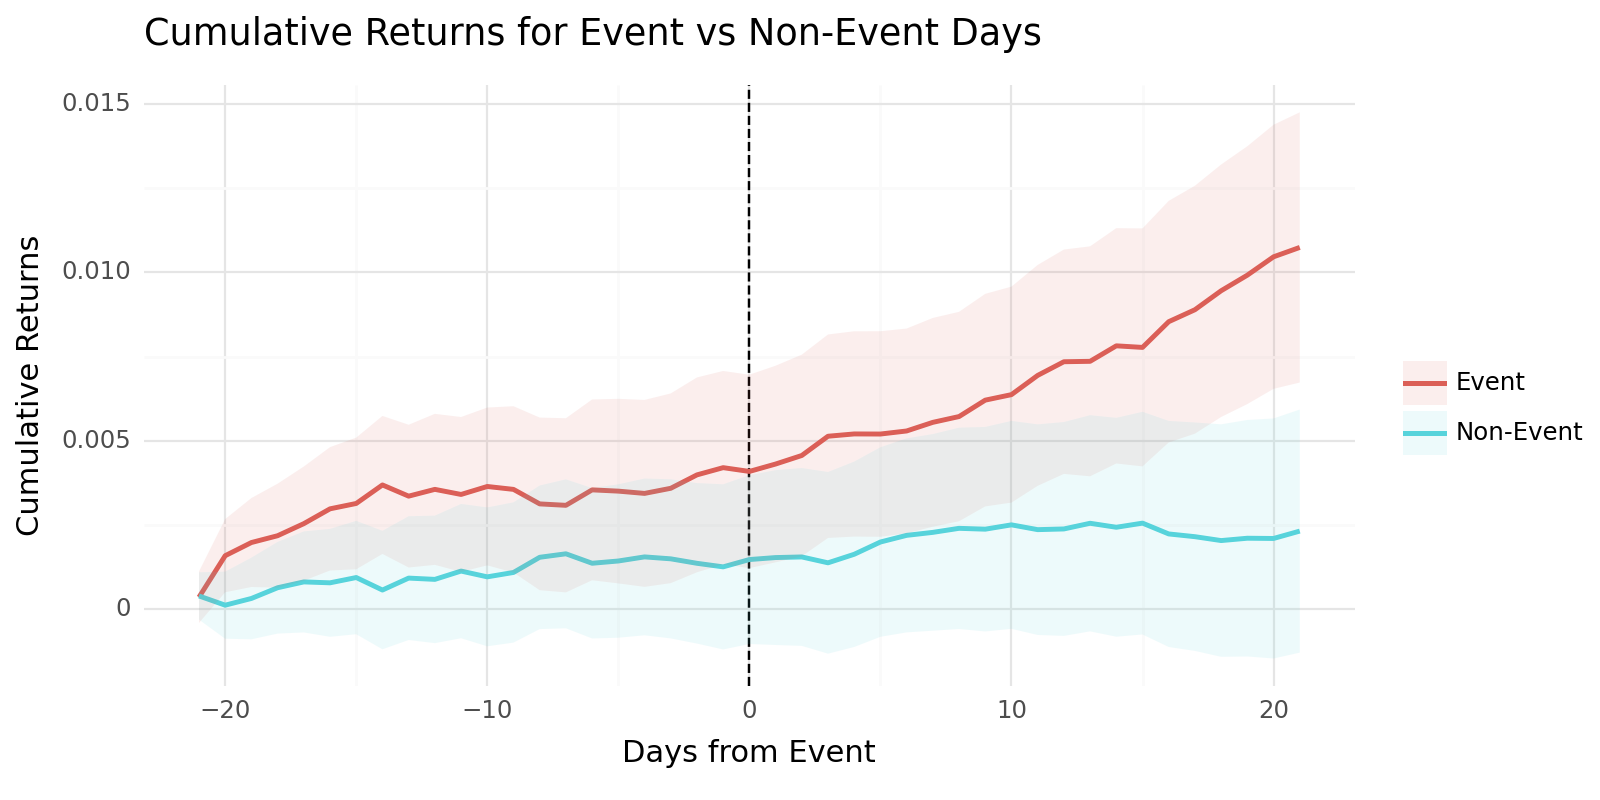

<Figure Size: (800 x 400)>

In [145]:
(ggplot(plot_data, aes(x='obs_from_event', y='cumulative_return', color='type'))
     + geom_vline(xintercept=0, linetype='dashed', color='black')  # event date
     + geom_line(size=1.0)  # plot the lines for the two event curves
     + geom_ribbon(plot_data_conf, aes(ymin='lower', ymax='upper', fill='type'), alpha=0.1, size = 0) # confidence intervals
     + labs(title='Cumulative Returns for Event vs Non-Event Days',
            x='Days from Event', y='Cumulative Returns', color="", fill="")
     + theme_minimal()
     + theme(figure_size=(8, 4))
)

## Interpretation

The results of the event study on positive earnings surprises provide meaningful insights into the market reaction to these events, as indicated by both the t-test and the visual representation in the cumulative returns chart. These results suggest a statistically significant difference in cumulative returns around the event date compared to non-event days, supporting the hypothesis (H1) that positive earnings surprises lead to a statistically significant increase in stock returns.

Specifically, the t-statistic of 2.6501 exceeds the typical threshold of 2, indicating that the difference in returns is not due to random chance. The p-value of 0.0081 is below the commonly used significance level of 0.05, providing further evidence that the observed difference is statistically significant.

The cumulative returns chart compares the returns for event days (days with positive earnings surprises) against non-event days over a period of 43 days (21 days before and 21 days after the event). In the pre-event period (-21 to 0 days), both event and non-event days show slight increases in cumulative returns, but the event days generally maintain higher returns compared to non-event days. The confidence intervals for both groups overlap initially but start to diverge slightly as the event date approaches.

In the post-event period (0 to +21 days), the cumulative returns for event days increase more sharply and steadily compared to non-event days. The confidence intervals for event days widen but remain above those for non-event days, indicating a stronger positive trend. Non-event days maintain relatively flat cumulative returns, with minor fluctuations and narrower confidence intervals.

The statistically significant t-test result combined with the visual evidence from the cumulative returns chart suggests that positive earnings surprises have a meaningful impact on stock returns. Stocks that experience such positive earnings surprises (defined as Standardized Unexpected Earnings of more than 0.05 above the mean) show significantly higher cumulative returns compared to stocks on non-event days.

Investors seem to respond positively to unexpected positive earnings announcements, leading to sustained increases in stock prices. This supports the hypothesis that the market reacts favorably to positive earnings surprises, reflecting increased investor confidence and potentially revised future earnings expectations.

Overall, these results highlight the importance of earnings announcements in driving stock performance and the effectiveness of using event studies to analyze market reactions to such financial news. The findings provide empirical support for the hypothesis that positive earnings surprises lead to statistically significant increases in stock returns, confirming the positive impact of such surprises on investor behavior and market valuation.

# Assignment

Pick any accounting ratio of your choice from firm financial statements and determine if changes in this ratio influence stock returns around the earnings announcement date.  Carry this out cross sectionally, as demonstrated in this week's example.  

Create a written report with a minimum of one graph and one table for your results.  In your report, briefly develop an hypothesis based on the literature and reason how your findings correspond to your expectations. 
